# Анализ бизнес-показателей

Мы работаем в отделе маркетиноговой аналитик Яндекс-Афишы и у нас есть задание - помочь маркетологам снизить расходы: нужно отказаться от невыгодных источников трафика и перераспределить бюджет. В нашем распоряжении есть несколько файлов с информацией об источниках трафиков и заказов, которые мы исследуем.

Будем следовать плану:
- [изучим данные и подготовим их для дальнейшего анализа](#start)
- [рассчитаем продуктовые метрики](#product)
- [изучим показатели электронной коммерции](#e-com)
- [исследуем маркетинговые метрики](#market)
- [сформулируем выводы и рекомендации](#output)

## Загрузка данных и подготовка к анализу
<a id='start'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('C:\\Users\\Александр\Datasets/visits_log.csv')
orders = pd.read_csv('C:\\Users\\Александр\Datasets/orders_log.csv')
costs = pd.read_csv('C:\\Users\\Александр\Datasets/costs.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Приведем названия столбцов к нижнему регистру и немного их подредактируем. 
Также приведем столбцы с датами у нужному нам формату <a id='rename'></a>

In [4]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts'})
visits['start_ts'] = visits['start_ts'].astype('datetime64')
visits['end_ts'] = visits['end_ts'].astype('datetime64')


Дополнительно застрахуем себя от случаев, когда дата первого действия будет больше второго: найдем и отсечем такие казусы

In [5]:
display(visits[visits['start_ts'] > visits['end_ts']])

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


In [6]:
visits = visits.query('end_ts > start_ts')

In [7]:
visits.duplicated().sum()

0

Аналогичную предобработку проведем с остальными датасетами

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'buy ts': 'buy_ts'})
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [12]:
costs['dt'] = costs['dt'].astype('datetime64')

In [13]:
costs.duplicated().sum()

0

## Расчет метрик и построение графиков

### Продуктовые метрики
<a id='product'></a>

#### MAU, WAU, DAU. 

Задача - вычислить средние значения указанных метрик за весь период и отобразить изменения метрик во времени на графиках

In [14]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451


Для дальнейшего удобных расчетов выделим из даты сессий месяц, неделю и день

In [15]:
visits['session_year']  = visits['start_ts'].dt.to_period('Y')
visits['session_month'] = visits['start_ts'].dt.to_period('M')
visits['session_week']  = visits['start_ts'].dt.to_period('W')
visits['session_date'] = visits['start_ts'].dt.to_period('D')

Теперь рассчитаем непосредственно сами метрики.

In [16]:
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).mean()
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()

Построим графики изменения метрик во времени. Начнем с MAU.

In [17]:
visits_month = visits.groupby('session_month').agg({'uid': 'nunique'}).reset_index()

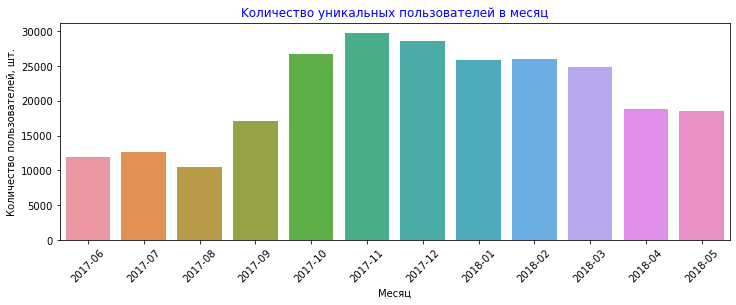

In [18]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x=visits_month['session_month'], y=visits_month['uid'], data=visits_month)
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей, шт.')
plt.title('Kоличество уникальных пользователей в месяц', color = 'blue')
plt.show()

Больше всего уникальных посетителей приходят в Афишу в период с ноября по февраль. Видимо, это связано с праздниками: на данное время приходится и Новый год, и 23 февраля с 8 марта. Заметен спад в теплое время года: возможно, именно здесь кроется потенциал для привлечения новых юзеров

Продолжим с WAU

In [19]:
visits_week = visits.groupby('session_week').agg({'uid': 'nunique'}).reset_index()

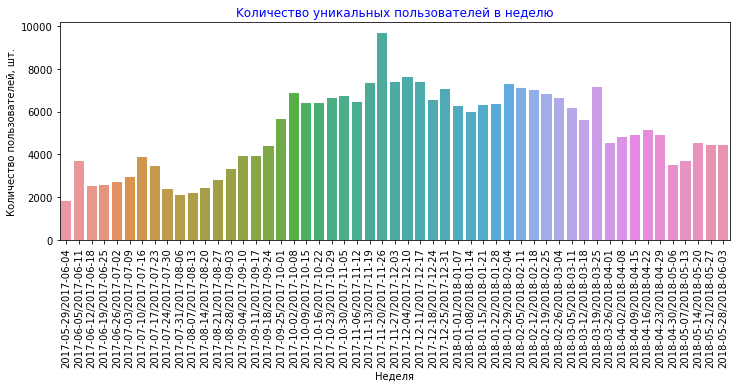

In [20]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x=visits_week['session_week'], y=visits_week['uid'], data=visits_week)
plt.xticks(rotation=90)
plt.xlabel('Неделя')
plt.ylabel('Количество пользователей, шт.')
plt.title('Kоличество уникальных пользователей в неделю', color = 'blue')
# альтернатива менее наглядна visits_week.plot(figsize=(12, 4), grid=True)
plt.show()

Недельный график нам также говорит о том, что наибольший всплекс посетителей приходится на указанные выше праздники

И закончим DAU

In [21]:
visits_day = visits.groupby('session_date').agg({'uid': 'nunique'}).reset_index()

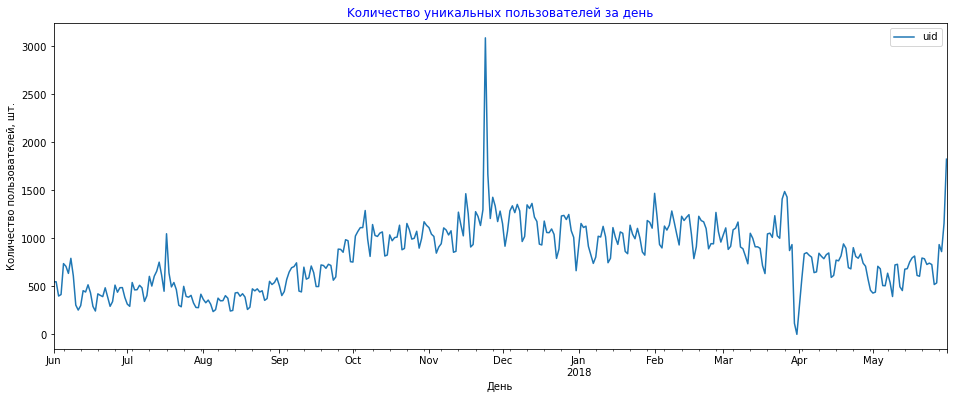

In [22]:
visits_day.plot.line(x='session_date', y='uid', figsize=(16, 6))
plt.xlabel('День')
plt.ylabel('Количество пользователей, шт.')
plt.title('Kоличество уникальных пользователей за день', color = 'blue')
plt.show()

Максимум, что видим по данному графику - это недельная сезонность: каждые 7 дней происходит локальный взлет и снова падение.

#### Сколько раз за день пользователи в среднем заходят на сайт?

Рассчитаем соответствующий показатель и добавим его в датасет

In [23]:
visits_per_user = visits.groupby(['session_year', 'session_month', 'session_week', 'session_date']).agg({'uid': ['count', 'nunique']})
visits_per_user.columns = ['n_visits', 'n_users']
visits_per_user['sessions_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']
visits_per_user = visits_per_user.reset_index()
visits_per_user.head()

,session_year,session_month,session_week,session_date,n_visits,n_users,sessions_per_user
0,2017,2017-06,2017-05-29/2017-06-04,2017-06-01,599,547,1.095064
1,2017,2017-06,2017-05-29/2017-06-04,2017-06-02,596,549,1.085610
2,2017,2017-06,2017-05-29/2017-06-04,2017-06-03,429,400,1.072500
3,2017,2017-06,2017-05-29/2017-06-04,2017-06-04,447,416,1.074519
4,2017,2017-06,2017-06-05/2017-06-11,2017-06-05,807,738,1.093496


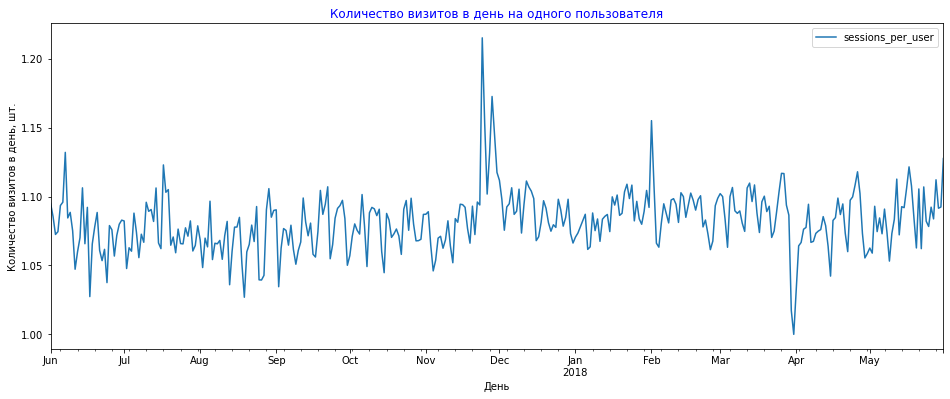

In [24]:
visits_per_user.plot(x='session_date', y='sessions_per_user', figsize=(16, 6))
plt.xlabel('День')
plt.ylabel('Количество визитов в день, шт.')
plt.title('Количество визитов в день на одного пользователя', color = 'blue')
plt.show()

Амплитуда довольна мала. чтобы делать какие-либо выводы. Но отчетливо видим 2 пика: на Новый год и в феврале. Это говорит о том, что людям требуется чуть больше сессий для принятия решения о покупке билетов, чем обычно

#### сколько времени пользователи проводят на сайте?

In [25]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12,2017-12-18/2017-12-24,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02,2018-02-19/2018-02-25,2018-02-19
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05,2018-05-14/2018-05-20,2018-05-20
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09,2017-08-28/2017-09-03,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01,2018-01-29/2018-02-04,2018-01-30


In [26]:
visits['duration'] = visits['end_ts'] - visits['start_ts']
visits['duration'] = visits['duration'].astype('timedelta64[m]')

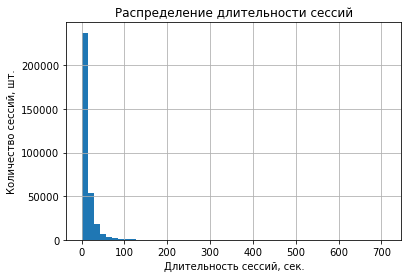

In [27]:
visits['duration'].hist(bins=50)
plt.title('Распределение длительности сессий')
plt.xlabel('Длительность сессий, сек.')
plt.ylabel('Количество сессий, шт.')
plt.show()

In [28]:
visits.describe()

,source_id,uid,duration
count,323604.000000,3.236040e+05,323604.000000
mean,3.732383,9.200880e+18,11.901976
std,1.924782,5.295512e+18,17.106407
min,1.000000,1.186350e+13,0.000000
25%,3.000000,4.614964e+18,2.000000
50%,4.000000,9.224491e+18,6.000000
75%,4.000000,1.372109e+19,15.000000
max,10.000000,1.844668e+19,711.000000


Медиана со средним расходятся в 2 раза, поэтому за основной показатель возьмем медиану. Конечно же, есть выбросы как в большую, так и меньшую сторону. Но это нормально: некоторые люди могут подолгу зависать на сервис; а минимальные нулевые значения можно принять за технические сбои. Их немало: разработчикам нужно найти, на нашей ли стороне проблема, и решить ее

#### Рассчитаем Retention Rate

In [29]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12,2017-12-18/2017-12-24,2017-12-20,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02,2018-02-19/2018-02-25,2018-02-19,28.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05,2018-05-14/2018-05-20,2018-05-20,24.0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09,2017-08-28/2017-09-03,2017-09-03,1.0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01,2018-01-29/2018-02-04,2018-01-30,56.0


Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность.
Эти данные запишем в объект Series. Объединим его с исходным датафреймом:

In [30]:
first_start_ts = visits.groupby('uid')['start_ts'].min()
first_start_ts.name = 'first_start_ts'
visits = visits.merge(first_start_ts, how='left', on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration,first_start_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12,2017-12-18/2017-12-24,2017-12-20,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02,2018-02-19/2018-02-25,2018-02-19,28.0,2018-02-19 16:53:00
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05,2018-05-14/2018-05-20,2018-05-20,24.0,2018-03-09 20:05:00
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09,2017-08-28/2017-09-03,2017-09-03,1.0,2017-09-03 21:35:00
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01,2018-01-29/2018-02-04,2018-01-30,56.0,2017-06-29 09:00:00


Выделим месяц из даты

In [31]:
visits['first_start_ts_month'] = visits['first_start_ts'].astype('datetime64[M]')
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')

In [32]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration,first_start_ts,first_start_ts_month,start_ts_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12,2017-12-18/2017-12-24,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02,2018-02-19/2018-02-25,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05,2018-05-14/2018-05-20,2018-05-20,24.0,2018-03-09 20:05:00,2018-03-01,2018-05-01
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09,2017-08-28/2017-09-03,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01,2018-01-29/2018-02-04,2018-01-30,56.0,2017-06-29 09:00:00,2017-06-01,2018-01-01


Определим срок жизни когорты в месяцах

In [33]:
visits['cohort_lifetime'] = visits['start_ts_month'] - visits['first_start_ts_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,duration,first_start_ts,first_start_ts_month,start_ts_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12,2017-12-18/2017-12-24,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02,2018-02-19/2018-02-25,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05,2018-05-14/2018-05-20,2018-05-20,24.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09,2017-08-28/2017-09-03,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01,2018-01-29/2018-02-04,2018-01-30,56.0,2017-06-29 09:00:00,2017-06-01,2018-01-01,7


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»

In [34]:
cohorts = visits.groupby(['first_start_ts_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts.head()

,first_start_ts_month,cohort_lifetime,uid
0,2017-06-01,0,11885
1,2017-06-01,1,900
2,2017-06-01,2,606
3,2017-06-01,3,710
4,2017-06-01,4,777


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [35]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_start_ts_month', 'uid']]
initial_users_count.head()

,first_start_ts_month,uid
0,2017-06-01,11885
12,2017-07-01,11825
23,2017-08-01,9214
33,2017-09-01,15125
42,2017-10-01,23538


In [36]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [37]:
cohorts = cohorts.merge(initial_users_count,on='first_start_ts_month') 

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [38]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

Построим сводную таблицу и создадим тепловую карту


In [39]:
retention_pivot = cohorts.pivot_table(
    index='first_start_ts_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum')[range(1, 12)]

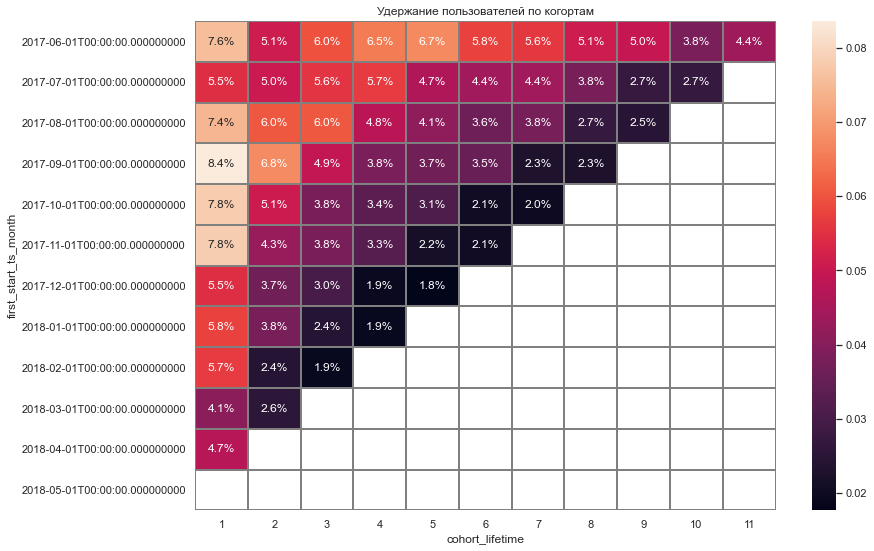

In [40]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Удержание пользователей по когортам')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

Retention Rate убывает по когортам с течением времени. Это говорит о том, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

### Метрики электронной коммерции
<a id='e-com'></a>

#### Cколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

Для расчета нам понадобятся 4 столбца: пользователь (есть), дата первого визита (есть у нас -  visits.first_start_ts), дата первого заказа и разница во времени. Найдем 3, а затем рассчитаем 4ый

In [41]:
first_buy_ts = orders.groupby('uid')['buy_ts'].min()
first_buy_ts.name = 'first_buy_ts'

In [42]:
first_buy_ts = first_buy_ts.reset_index()
first_start_ts = first_start_ts.reset_index()

Создадим фрейм, в котором и будут наши 4 желанных столбца

In [43]:
diff = first_buy_ts.merge(first_start_ts, on='uid')

In [44]:
diff['diff'] = diff['first_buy_ts'] - diff['first_start_ts']
diff['diff'] = diff['diff'].astype('timedelta64[D]')
diff = diff.query('first_buy_ts > first_start_ts')
#diff.head()

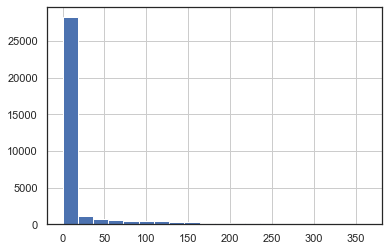

In [45]:
diff['diff'].hist(bins=20)
plt.show()

In [46]:
diff.describe()

,uid,diff
count,3.356800e+04,33568.000000
mean,9.208177e+18,16.654016
std,5.322937e+18,46.674513
min,3.135781e+14,0.000000
25%,4.611322e+18,0.000000
50%,9.235914e+18,0.000000
75%,1.382722e+19,2.000000
max,1.844617e+19,363.000000


Из описания видим, что среднее сильно различается с медианой, и как будто бы у нас много выбросов. Но на самом деле все это вполне объяснимо: человек, впервые зашедший на сайт магазина, с большой долей вероятности сделает свой первый заказ в этот же день.

#### Cреднее количество покупок на одного покупателя

In [47]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Механика похожа на расчет когорт по пользовательской активности, который мы делали ранее: выделяем месяц первого заказа

In [48]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'

Объединяем выделенный месяц с существующей таблицей заказов

In [49]:
orders = orders.join(first_order_date, on='uid')
orders.head()

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Выделяем месячные когорты

In [50]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Получаем количество уникальных покупателей в каждой когорте

In [51]:
cohort_sizes = (
    orders.groupby('first_order_month') #, 'order_month']
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head() 

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Получаем количество пользователей в каждой когорте

In [52]:
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'buy_ts': 'count'})
    .reset_index()
)
cohorts.head()

,first_order_month,order_month,buy_ts
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


А теперь объединим эти таблицы

In [53]:
output = pd.merge(cohort_sizes, cohorts, on='first_order_month')
output.head(15)

,first_order_month,n_buyers,order_month,buy_ts
0,2017-06-01,2023,2017-06-01,2354
1,2017-06-01,2023,2017-07-01,177
2,2017-06-01,2023,2017-08-01,174
3,2017-06-01,2023,2017-09-01,226
4,2017-06-01,2023,2017-10-01,292
5,2017-06-01,2023,2017-11-01,218
6,2017-06-01,2023,2017-12-01,276
7,2017-06-01,2023,2018-01-01,174
8,2017-06-01,2023,2018-02-01,212
9,2017-06-01,2023,2018-03-01,153


И рассчитаем количество заказов на одного человека

In [54]:
output['order_per_user'] = output['buy_ts'] / output['n_buyers']

In [55]:
output.head(15)

,first_order_month,n_buyers,order_month,buy_ts,order_per_user
0,2017-06-01,2023,2017-06-01,2354,1.163618
1,2017-06-01,2023,2017-07-01,177,0.087494
2,2017-06-01,2023,2017-08-01,174,0.086011
3,2017-06-01,2023,2017-09-01,226,0.111715
4,2017-06-01,2023,2017-10-01,292,0.144340
5,2017-06-01,2023,2017-11-01,218,0.107761
6,2017-06-01,2023,2017-12-01,276,0.136431
7,2017-06-01,2023,2018-01-01,174,0.086011
8,2017-06-01,2023,2018-02-01,212,0.104795
9,2017-06-01,2023,2018-03-01,153,0.075630


Построим сводную таблицу, которая отобразит изменение среднего количества заказов на одного человека в каждой когорте

In [56]:
output.pivot_table(index='first_order_month', columns='order_month', values='order_per_user', aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,1.163618,0.087494,0.086011,0.111715,0.144340,0.107761,0.136431,0.086011,0.104795,0.075630,0.047454,0.042511,NaN
2017-07-01,NaN,1.136765,0.052002,0.062402,0.054082,0.037441,0.042642,0.031721,0.026001,0.030161,0.012480,0.027561,NaN
2017-08-01,NaN,NaN,1.118978,0.078832,0.072993,0.059124,0.062044,0.045255,0.035766,0.056934,0.033577,0.033577,NaN
2017-09-01,NaN,NaN,NaN,1.136381,0.084851,0.062379,0.063541,0.025959,0.042232,0.041844,0.021697,0.023634,NaN
2017-10-01,NaN,NaN,NaN,NaN,1.143779,0.072350,0.037327,0.028111,0.029724,0.023733,0.019816,0.028802,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,1.179368,0.097280,0.044597,0.051703,0.033325,0.014457,0.024994,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,1.152635,0.061602,0.046087,0.040840,0.019621,0.023956,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.121554,0.066410,0.047139,0.018974,0.023125,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.121611,0.060805,0.022733,0.019173,NaN


#### Средний чек

У нас есть таблица заказов со всеми нужными исходными данными. Чтобы посчитать средний чек, сгруппируем фрейм по месяцам и узнаем медианную стоимость заказа. Медиана все-таки не чувствительна к выбросам, поэтому для расчета подходит именно она

In [57]:
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [58]:
avg_check = orders.groupby('order_month')['revenue'].median().reset_index()
avg_check['order_month'] = avg_check['order_month'].dt.to_period('M')
#avg_check.head()
#avg_check.info()

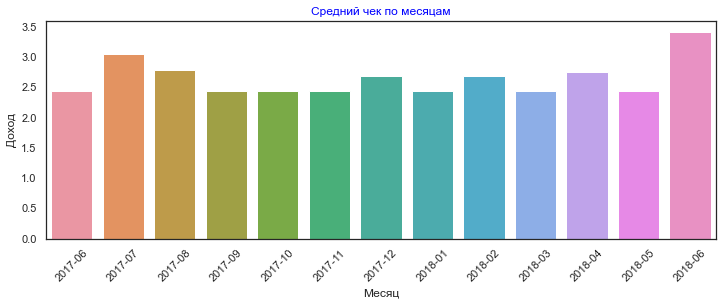

In [59]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x=avg_check['order_month'], y=avg_check['revenue'], data=avg_check)
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Доход')
plt.title('Средний чек по месяцам', color = 'blue')
plt.show()

Это интересно. Несмотря на то, что в холодные месяца количество посетителей и продолжительность сессий ниже, средний чек гораздо ниже. Возможно, это связано с тем, что на Новый год и праздники сервис предоставляет скидки, а в остальное время люди пользуются услугами Афиши без скидок. Таким образом делаем вывод, что с помощью скидок удается привлекать дополнительное количество клиентов, пусть и с чуть меньшим средним чеком

#### LTV

In [60]:
orders.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [61]:
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

In [62]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head(15)

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
5,2017-06-01,2023,2017-11-01,1487.92
6,2017-06-01,2023,2017-12-01,1922.74
7,2017-06-01,2023,2018-01-01,1176.56
8,2017-06-01,2023,2018-02-01,1119.15
9,2017-06-01,2023,2018-03-01,1225.51


По условиям задачи маржинальность сервиса составляет 100%, поэтому операции с revenue не проводим

LTV удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты. Его и рассчитаем

In [63]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

report.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


создадим сводник, где визуально и изучим LTV

In [64]:
output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)
#отсечем те когорты, срок жизни которых меньше 6 месяцев
output = output.loc['2017-06-01': '2017-12-01']
 
#посчитаем LTV накопительным итогом
output = output.cumsum(axis=1)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN


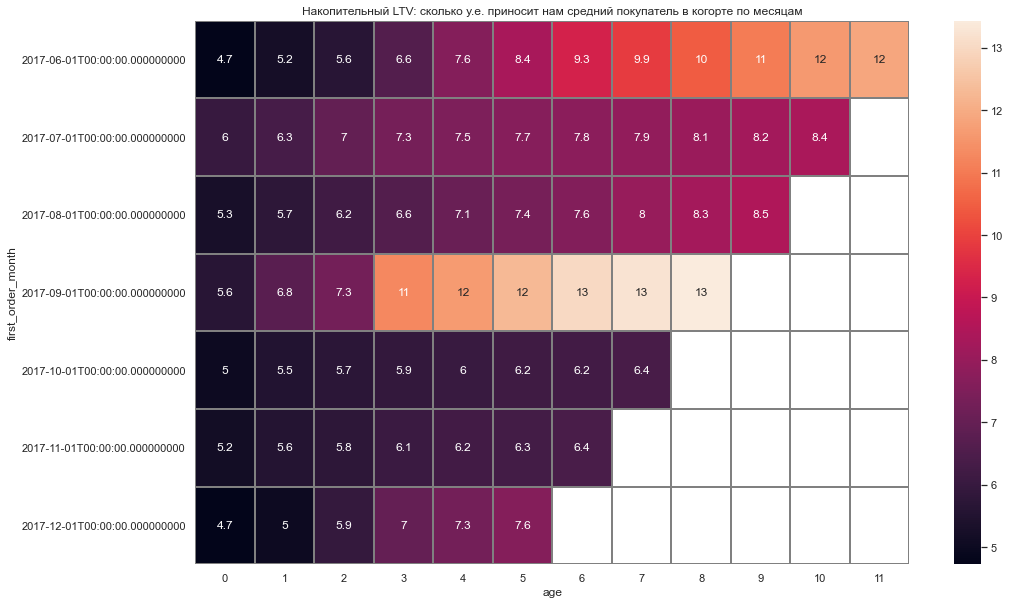

In [65]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Накопительный LTV: сколько у.е. приносит нам средний покупатель в когорте по месяцам')
plt.xlabel('Процент возврата')
plt.ylabel('Месячная когорта')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray')
plt.show()

Как видим, самые прибыльные когорты - июня, сентября и декабря. Коллегам стоит поднять информацию и выяснить, какие маркетинговые активности они проводили в данные периоды - те, которые привели пользователя к первому шагу. После этого, разумеется, стоит масштабировать усилия для создания таких же и даже более прибыльных аудиторий

### Маркетинговые метрики
<a id='market'></a>

#### Общая сумма расходов на маркетинг. Распределение по источникам

In [66]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [67]:
#costs.info()

In [68]:
costs['month'] = costs['dt'].dt.to_period('M')

In [69]:
#сгруппируем расхожы по месяцам и посчитаем суммы
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
#costs_per_source.head()


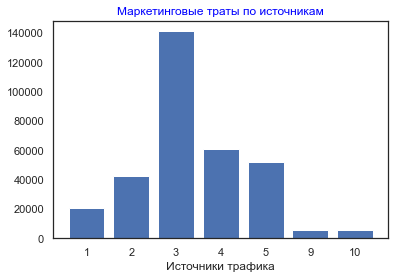

In [70]:
#построим сравнительные графики расходов по источникам, чтобы видеть различия
y_pos = np.arange(len(costs_per_source['source_id']))
plt.bar(y_pos, costs_per_source['costs'])
plt.xticks(y_pos, costs_per_source['source_id'])
plt.title('Маркетинговые траты по источникам', color = 'blue')
plt.xlabel('Источники трафика')
plt.show()


In [71]:
#рассчитаем динамику расходов по источникам в месяц
costs_per_source_month = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
costs_per_source_month.head()

,month,source_id,costs
0,2017-06,1,1125.61
1,2017-06,2,2427.38
2,2017-06,3,7731.65
3,2017-06,4,3514.80
4,2017-06,5,2616.12


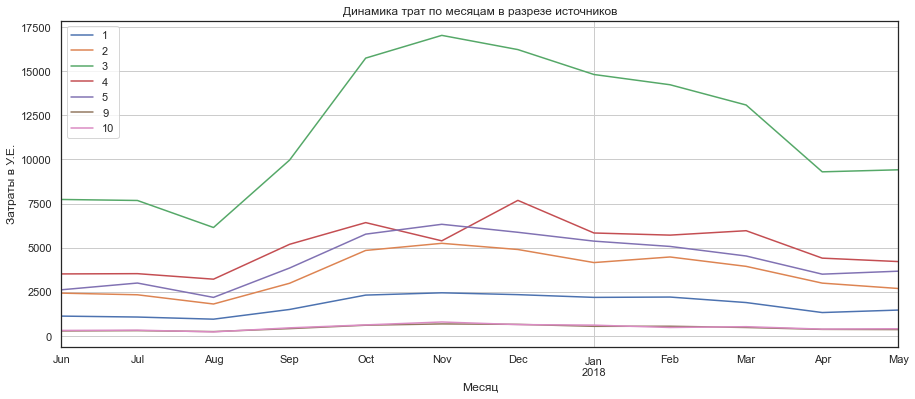

In [72]:
fig, ax = plt.subplots(figsize = (15,6))
costs_per_source_month.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum').plot(ax=ax)
plt.xlabel('Месяц')
plt.ylabel('Затраты в У.Е.')
plt.title('Динамика трат по месяцам в разрезе источников')
plt.grid(True)
ax.legend(loc='upper left')
plt.show()

#### Средний САС на одного покупателя по источникам

Чтобы посчитать САС на одного покупателя по источникам, будем следовать такому алгоритму:
- найдем общие затраты на рекламу для пары источник+месяц
- найдем общее число покупателей для пар первый источник+первый месяц
- объединим две таблицы и поделим затраты на покупателей.

In [73]:
#группировать будем по источнику
group = ['source_id']

In [74]:
#считаем расходы
monthly_cost_source = costs.groupby(group)['costs'].sum()
monthly_cost_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [75]:
#группируем по пользователю и находим первый месяц и первый источник
users = visits.sort_values(by=['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 'session_month': 'first'})
users = users.reset_index().rename(columns={'session_month': 'month'})
#users.head()

In [76]:
#теперь отбираем только плательщиков и также их группируем
buyers = users.query('uid in @orders.uid')
buyers = buyers.groupby(group).agg({'uid': 'nunique'})
#buyers.head()

In [77]:
#теперь объединим таблицы и рассчитаем показатель
cost_per_buyer = buyers.join(monthly_cost_source)
cost_per_buyer['cac'] = cost_per_buyer['costs'] / cost_per_buyer['uid']
cost_per_buyer.reset_index()

,source_id,uid,costs,cac
0,1,2964,20833.27,7.028769
1,2,3515,42806.04,12.178105
2,3,10248,141321.63,13.790167
3,4,10113,61073.60,6.039118
4,5,6847,51757.10,7.559092
5,7,1,NaN,NaN
6,9,1087,5517.49,5.075888
7,10,1306,5822.49,4.458262


Как видим, самое дорогое привлечение клиента приходится на 2 и 3 источник

####  ROMI по когортам в разрезе источников. Окупаемость за одинаковые периоды жизни когорт. 

Для каждого пользователя по таблице visits найдем первый источник, из которого он пришел. Потом эту информацию привяжем к покупкам пользователя и для каждого источника построитмотдельный хитмап с ltv и roi. Все это сделаем через функцию и цикл, так как источников у нас несколько


1


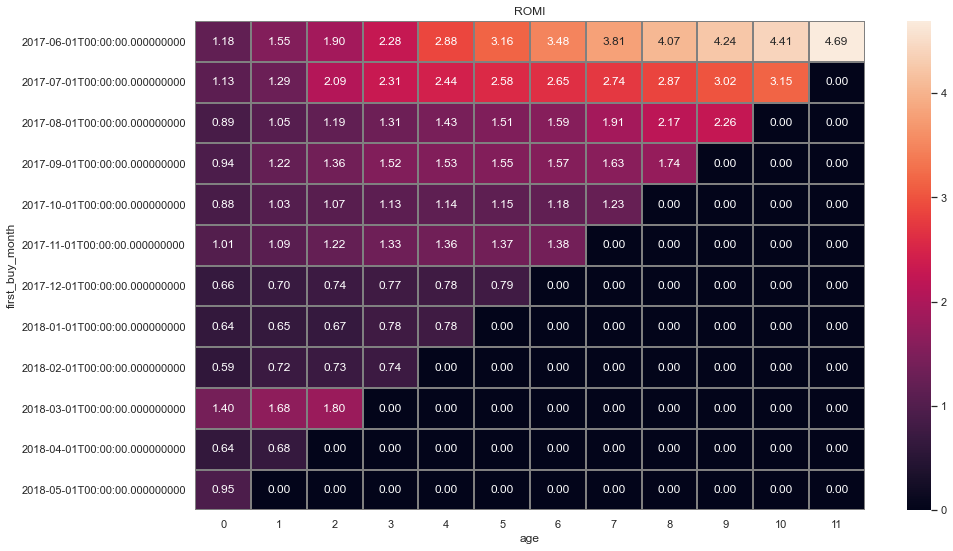

2


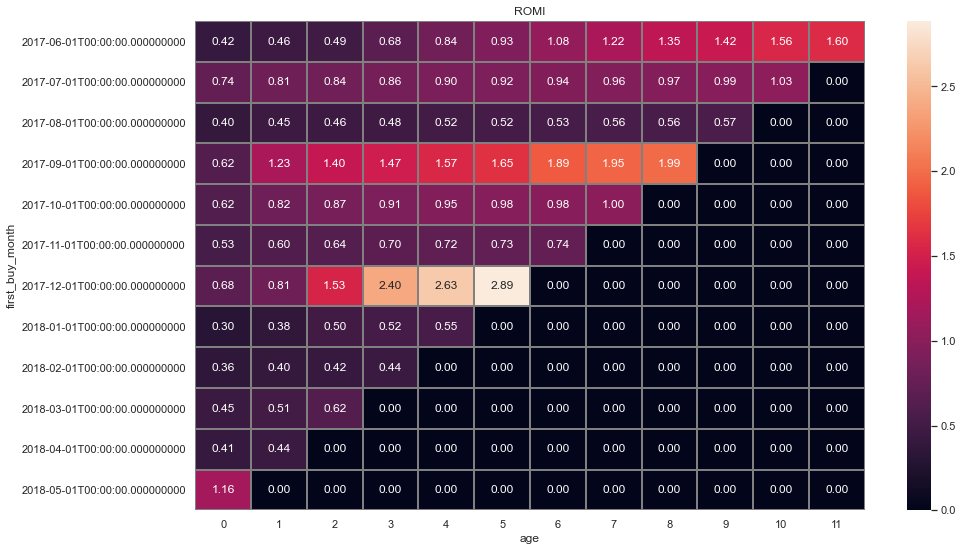

3


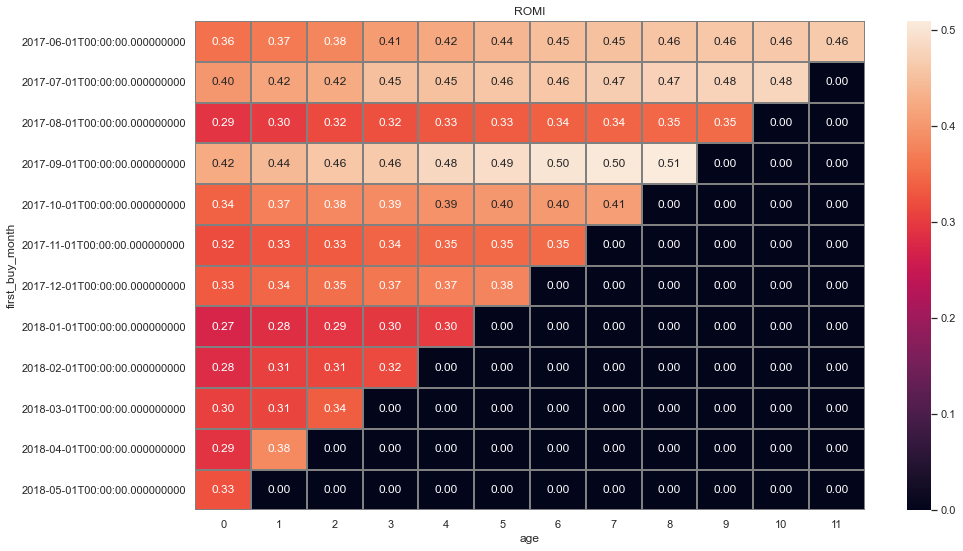

4


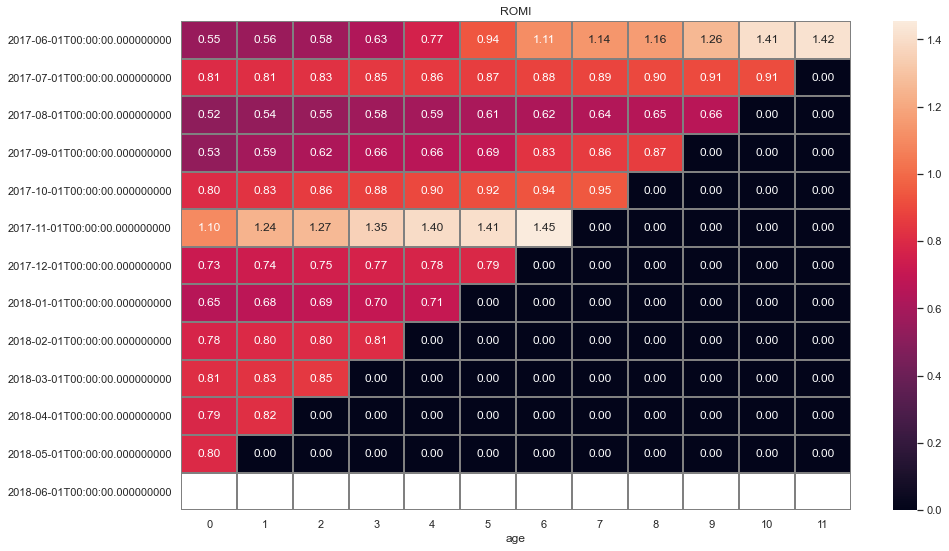

5


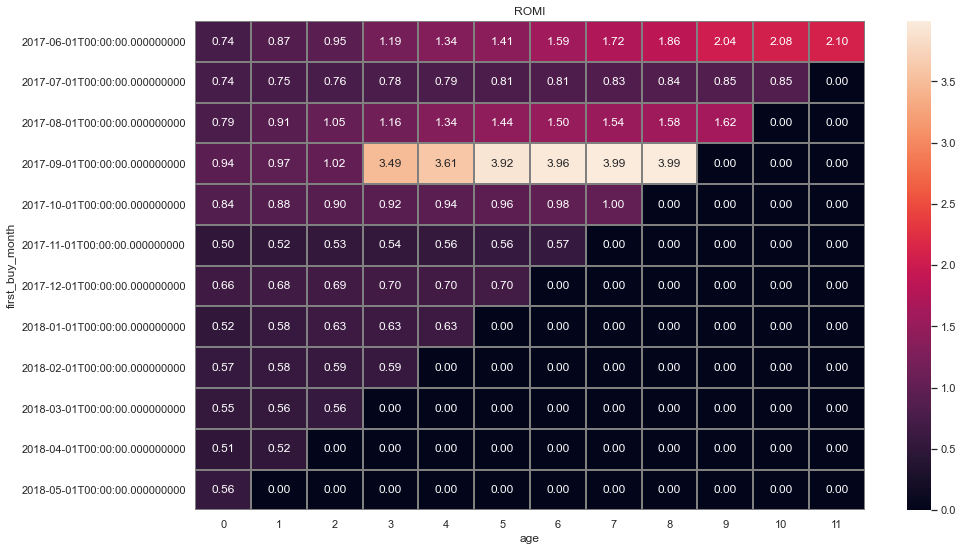

9


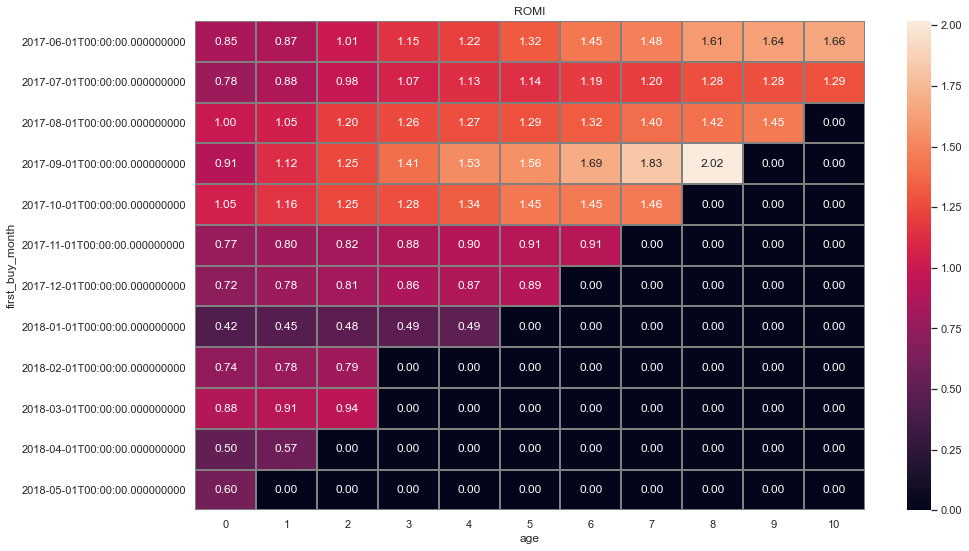

10


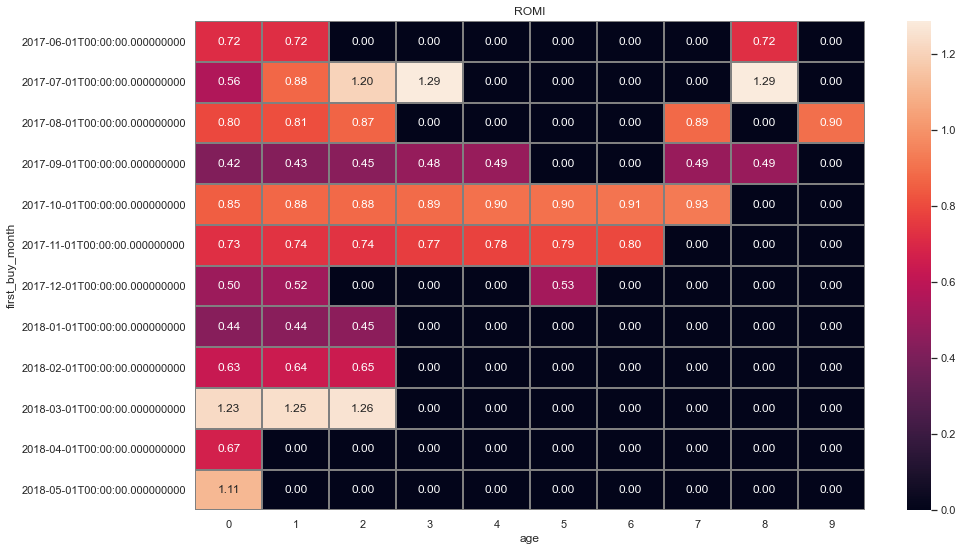

In [78]:
users = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id':'first', 'session_month':'first'})
orders_newest = orders.merge(orders.groupby('uid').agg({'order_month': 'min'})
                                    .reset_index().rename(columns = {'order_month': 'first_buy_month'}),
                             on = 'uid')
def Romi(source):
    #for sources  in sources:
    source_users = users.query('source_id == @source').index.values
    source_orders = orders_newest.query('uid in @source_users')
    cohort_sizes = (source_orders.groupby('first_buy_month').agg({'uid' : 'nunique'}).reset_index())
    # ситуация, когда покупателей нет приводит к ошибкам
    if cohort_sizes.shape[0] == 0: 
        print('Для источника {} нет данных о покупателях'.format(source))
        return 
    cohort_sizes.columns = ['first_buy_month', 'n_buyers']
    cohorts = (source_orders.groupby(['first_buy_month', 'order_month']).agg({'revenue' : 'sum'}).reset_index())
    report = pd.merge(cohort_sizes, cohorts, on = 'first_buy_month')
    margin_rate=1.0
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    output = report.pivot_table(
         index='first_buy_month', columns='age', values='ltv', aggfunc='mean'
    )
    output = output.cumsum(axis=1).fillna(0)
    source_costs = costs.query('source_id == @source')
    source_costs['month_dt'] = source_costs['dt'].astype('datetime64[M]')
    source_costs = source_costs.groupby('month_dt').agg({'costs' : 'sum'})
    source_costs = source_costs.join(cohort_sizes.set_index('first_buy_month'))
    #source_costs = source_costs.reset_index()
    #source_costs = pd.merge(source_costs, cohort_sizes, left_on='month_dt', right_on='first_buy_month')
    source_costs['cac'] = source_costs['costs'] / source_costs['n_buyers']
    
    output = output.div(source_costs['cac'], axis=0)

    print(source)
    sns.set(style='white')
    plt.figure(figsize=(15, 9))
    plt.title('ROMI')
    sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.show()
    return plt.show()
sources = [1, 2, 3, 4, 5, 9, 10]
for source in sources: 
    Romi(source)

## Выводы и рекомендации
<a id='output'></a>

### Источники трафика

В целом, исходя из анализа ROMI, можем посоветовать нашим коллегам использовать следующие источники:
- 1 (тут окупаемость для большинства когорт приходит на 1-2 месяц)
- 9 (аналогично)
- 5 (только 5 первых когорт)

Отказаться стоит от источников:
- 2 (обратить внимание на когорты июня, сентября и декабря)
- 3 
- 4 (но можно обратить внимание на когорты июня и ноября: почему они выбиваются из остальных когорт в положительную сторону)

По источнику 10 данных мало, оценку дать ему трудно

### Метрики

Если говорить о продуктовых метриках, то следует отметить следующее.Больше всего уникальных посетителей приходят в Афишу в период с ноября по февраль. Видимо, это связано с праздниками: на данное время приходится и Новый год, и 23 февраля с 8 марта. Заметен спад в теплое время года: возможно, именно здесь кроется потенциал для привлечения новых юзеров

Retention Rate убывает по когортам с течением времени. Это говорит о том, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

Минимальные нулевые значения по продолжительности пользовательских сессий  можно принять за технические сбои. Их немало: разработчикам нужно найти, на нашей ли стороне проблема, и решить ее

Если говорить о метриках электронной коммерции, то стоит обратить внимание на средний чек и LTV. Несмотря на то, что в холодные месяца количество посетителей и продолжительность сессий ниже, средний чек гораздо ниже. Возможно, это связано с тем, что на Новый год и праздники сервис предоставляет скидки, а в остальное время люди пользуются услугами Афиши без скидок. Таким образом делаем вывод, что с помощью скидок удается привлекать дополнительное количество клиентов, пусть и с чуть меньшим средним чеком.

Самые прибыльные когорты - июня, сентября и декабря. Коллегам стоит поднять информацию и выяснить, какие маркетинговые активности они проводили в данные периоды - те, которые привели пользователя к первому шагу. После этого, разумеется, стоит масштабировать усилия для создания таких же и даже более прибыльных аудиторий

Рассуждая о маркетинговых метриках, стоит отметить сильно выбивающийся по расходам 3 источник. Если бы с его помощью мы генерировали лиды, которые быстро окупались и приносили гораздо больший доход, то можно было бы его и оставить. Но ROMI по нему отрицательный. Поэтому прощаемся с ним.